In [69]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
# import tdt
import trompy as tp

import dill

from extract_behav_parameters import get_ttls, read_DLC_csv, interpolate_low_likehood, calc_angular_velocity, calc_stillness, calc_bodypart_movement, get_behav_snips, smooth_array

colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
DATAFOLDER = Path("..//data")
TANKFOLDER = Path("D://TestData//bazzino//from_paula")
DLCFOLDER = TANKFOLDER / "Sodium_Appetite_DLC" #office computer, Paula's tracking
DLCFOLDER = Path("D:/TestData/bazzino/output_csv_shuffle4") #office computer, Dionne's tracking
# DLCFOLDER = Path("C:/Users/jmc010/Data/bazzino/Output DLC shuffle 4 csv files") # laptop

In [ ]:
stub = "PB71-221123-113609"
# get_ttls(stub, DATAFOLDER, TANKFOLDER)
dlcdata = read_DLC_csv(stub, DLCFOLDER)
df = interpolate_low_likehood(dlcdata, threshold=0.6)
# df = calc_angular_velocity(df, rightear="r_ear", leftear="l_ear")
movement = calc_bodypart_movement(df)

D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-221123_PB71-221123-113609_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv


In [82]:
dlcdata.columns

Index(['bodyparts_coords', 'nose_x', 'nose_y', 'nose_likelihood', 'l_ear_x',
       'l_ear_y', 'l_ear_likelihood', 'r_ear_x', 'r_ear_y', 'r_ear_likelihood',
       'head_base_x', 'head_base_y', 'head_base_likelihood', 'back1_x',
       'back1_y', 'back1_likelihood', 'back2_x', 'back2_y', 'back2_likelihood',
       'back3_x', 'back3_y', 'back3_likelihood', 'back4_x', 'back4_y',
       'back4_likelihood', 'tail_base_x', 'tail_base_y',
       'tail_base_likelihood', 'tail1_x', 'tail1_y', 'tail1_likelihood',
       'tail2_x', 'tail2_y', 'tail2_likelihood', 'tail3_x', 'tail3_y',
       'tail3_likelihood', 'tail_tip_x', 'tail_tip_y', 'tail_tip_likelihood'],
      dtype='object')

In [85]:
def get_angular_velocity(stub, dlcfolder, zscore=False):
    
    df = read_DLC_csv(stub, dlcfolder) 
    df = interpolate_low_likehood(df, threshold=0.5)
    df = calc_angular_velocity(df, rightear="r_ear", leftear="l_ear")
    
    return df.d_angle_deg

def get_movement(stub, dlcfolder):
    
    df = read_DLC_csv(stub, dlcfolder)
    df = interpolate_low_likehood(df, threshold=0.6)
    movement = calc_bodypart_movement(df, 
                                      # weight_by_zscore=True,
                                      include_bodyparts=["r_ear", "l_ear", "nose", "head_base"],
                                      smooth_method="gaussian", smooth_window=5,
                                      )
    
    return movement

def get_stillness(stub, dlcfolder):
    
    df = read_DLC_csv(stub, dlcfolder)
    df = interpolate_low_likehood(df, threshold=0.5)
    df = calc_stillness(df)
    
    return df.stillness_z



D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-220926_PB48-220926-121542_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv


<Axes: >

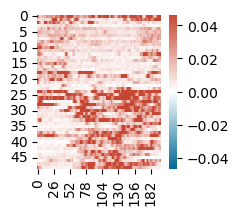

In [ ]:
## For testing purposes
stub = "PB71-221123-113609" 
# stub = "PB75-221123-140659" #0.45, deplete
stub = "PB61-221024-110730" #0.10, deplete
stub = "PB71-221123-113609" #0.45, deplete
stub = "PB26-220608-113244" #0.45, deplete
stub = "PB75-221123-140659" #0.45, deplete
stub = "PB73-221123-131413" #0.45, deplete
stub = "PB48-220926-121542" #0.45, deplete

snips = get_behav_snips(solenoid_ts=get_ttls(stub, DATAFOLDER, TANKFOLDER),
                        behav_vector=get_movement(stub, DLCFOLDER),
                        # zscore_to_entire_snips=True,
                        # zscore_to_baseline=True
)

def scale_vlim_to_data(snips, percentile=99):
    # Get the vlim values for the heatmap based on the data distribution
    vlim = np.percentile(np.abs(snips), percentile)
    return -vlim, vlim

pc = 90

f, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(snips,
            vmin=scale_vlim_to_data(snips, percentile=pc)[0],
            vmax=scale_vlim_to_data(snips, percentile=pc)[1],
            ax=ax,
            cmap=custom_cmap
            )

In [126]:
def tweak_x_array(x_array):

    df = pd.concat(x_array, axis=0)

    return (df
            .replace({"condition": {"Sodium Depleted": "deplete",
                                    "Sodium Replete": "replete",
                                    "Sodium Replete Experienced": "replete_exp",
                                    "Thirsty": "thirsty",                                    
                                    },
                      "infusiontype": {45: "45NaCl",
                                       1: "10NaCl"
                                       }
                      })
            .reset_index(drop=True)
            )

def assemble_snips_and_x(meta_df, dlc_folder, snips_function):
    metadata = meta_df
    
    snips_array, x_array = [], []
    
    for row in metadata.iterrows():
        stub = row[1]["Folder"]
        
        print(stub)
        try:
            snips_tmp = get_behav_snips(solenoid_ts=get_ttls(stub, DATAFOLDER),
                        behav_vector=snips_function(stub, DLCFOLDER),
                        # zscore_to_entire_snips=True,
                        # zscore_to_baseline=True
                        )
            nsnips = len(snips_tmp)
            print(nsnips)
            snips_array.append(snips_tmp)
            
            x_array.append(pd.DataFrame(data={"trial": np.arange(nsnips),
                                                "id": row[1]["Subject"],
                                                "condition": row[1]["Physiological state"],
                                                "infusiontype": row[1]["TreatNum"]
                                                }
                                        )
                            )
        except:
            print("Error with tank for", row[1]["Subject"], row[1]['Physiological state'])
            
    snips_array = np.concatenate(snips_array, axis=0)
    x = tweak_x_array(x_array)

    return snips_array, x

meta_df = pd.concat([pd.read_csv(DATAFOLDER / "10NaCl_FileKey.csv"),
                      pd.read_csv(DATAFOLDER / "45NaCl_FileKey.csv")]
                    )

subjects_df = (pd
               .concat([pd.read_csv(DATAFOLDER / "10NaCl_SubjectKey.csv").iloc[:, :2],
                         pd.read_csv(DATAFOLDER / "45NaCl_SubjectKey.csv").iloc[:, :2]]
                        )
               .reset_index()
               .rename(columns={"Subject": "id",
                               "Sex": "sex"})
               .drop(columns=["index"])
)

snips, x_array = assemble_snips_and_x(meta_df, DLCFOLDER, get_movement)
x_array = pd.merge(x_array, subjects_df[['id', 'sex']], on='id', how='left')


PB23-220608-131619
D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-220608_PB23-220608-131619_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv
49
PB24-220608-122638
D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-220608_PB24-220608-122638_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv
49
PB33-220620-115414
D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-220620_PB33-220620-115414_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv
49
PB39-220629-105034
D:\TestData\bazzino\output_csv_shuffle4
Found file: D:\TestData\bazzino\output_csv_shuffle4\PB_NAapp-220629_PB39-220629-105034_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv
49
PB391-220829-111452
D:\TestData\bazzino\output_csv_shuffle4
Error: No DLC file found for stub PB391-220829-111452 with pattern PB_NAapp-220829_PB391-220

In [129]:
# code to only select the conditions we want - deplete and replete
snips_red = snips[(x_array.condition != "thirsty") & (x_array.condition != "replete_exp")]
x_array_red = x_array.query("condition != 'thirsty' & condition != 'replete_exp'")

data_to_save = {"snips_movement": snips_red,
                "x_movement": x_array_red,
                }

with open(DATAFOLDER / "movement_data.pickle", "wb") as f:
    dill.dump(data_to_save, f)



In [26]:
## pre-processing of the DLC angvel snips

# interpolation
df_snips_vel = pd.DataFrame(snips_vel)


df_interpolated = df_snips_vel.interpolate(method='linear', axis=1)
df_filled = df_interpolated.ffill(axis=1).bfill(axis=1)

snips_vel_processed = df_filled.to_numpy()

# find absolute
snips_vel_processed = np.abs(snips_vel_processed)

# how about instead of zscoring, we just adjust to baseline subtraction
baseline = np.nanmean(snips_vel_processed[:, :50], axis=1)
snips_vel_processed = snips_vel_processed - baseline[:, None]

print(np.sum(np.isnan(snips_vel_processed)))
snips_vel = np.array(snips_vel_processed)

# removing NaNs
rows_with_nans_mask = np.isnan(snips_vel).any(axis=1)
snips_vel = snips_vel[~rows_with_nans_mask]
x_vel = x_vel[~rows_with_nans_mask].reset_index(drop=True)
print(snips_vel.shape)
x_vel.shape

0
(1960, 200)


(1960, 5)